# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Citations

Dataset: This tech report (Chapter 3) describes the dataset and the methodology followed when collecting it in much greater detail. Please cite it if you intend to use this dataset.
[Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.

[Normalization values for transforms:](https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data)

[Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) - was referred by a very nice technical mentor I reached out to after going crazy all weekend with a feed-forward model that would not learn! :)



## Imports

In [6]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# My additional imports and magics & stuff
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from torchvision import datasets, models, transforms
from torch.utils.data.dataloader import DataLoader
import time
import os
import copy
from collections import OrderedDict
import os
plt.ion()   # interactive mode

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import tarfile
from torchvision.datasets.utils import download_url
#from torch.utils.data import random_split
from torch.utils.data.dataset import random_split




## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

Since I'm struggling to put this all together, let's start with images themselves and remove the complexity of using these batches and pytorch objects, as they are just one more thing that can go wrong and aren't necessary.

In [8]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [9]:
# Extract the data from tar file:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [10]:
# verifying the data is there:

data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes_list = os.listdir(data_dir + "/train")
print(classes_list)

['.DS_Store', 'test', 'train']
['cat', '.DS_Store', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile']


In [11]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0298.png', '0267.png', '0501.png', '0515.png', '0273.png']


In [12]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

Each element of this dataset contains an image tensor and a label. The images are 3-channels with dimensions of 32x32, so the expected tensor shape for each image will 3, 32, 32. The labels should just be a 1-dimensional tensor, but let's pick out an element to check that this is what we really have:

In [13]:
img, label = dataset[7]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.4431, 0.4314, 0.4353,  ..., 0.6039, 0.6431, 0.6745],
         [0.4471, 0.4314, 0.4353,  ..., 0.6667, 0.6235, 0.6314],
         [0.4588, 0.4549, 0.4471,  ..., 0.4902, 0.4471, 0.5294],
         ...,
         [0.2039, 0.2039, 0.2000,  ..., 0.6902, 0.6745, 0.6784],
         [0.1765, 0.1804, 0.2000,  ..., 0.6745, 0.6784, 0.6863],
         [0.1882, 0.2000, 0.2235,  ..., 0.6784, 0.6745, 0.6863]],

        [[0.3843, 0.3725, 0.3725,  ..., 0.5961, 0.6431, 0.6745],
         [0.3804, 0.3686, 0.3725,  ..., 0.6549, 0.6196, 0.6275],
         [0.3765, 0.3804, 0.3765,  ..., 0.4784, 0.4392, 0.5216],
         ...,
         [0.2039, 0.1961, 0.1843,  ..., 0.6627, 0.6549, 0.6588],
         [0.1882, 0.1804, 0.1961,  ..., 0.6510, 0.6549, 0.6667],
         [0.2039, 0.2039, 0.2235,  ..., 0.6588, 0.6510, 0.6667]],

        [[0.2706, 0.2588, 0.2627,  ..., 0.6078, 0.6510, 0.6824],
         [0.2706, 0.2627, 0.2706,  ..., 0.6667, 0.6314, 0.6392],
         [0.2588, 0.2745, 0.2706,  ..., 0.4902, 0.4510, 0.

In [14]:
print(dataset.classes) #this is a property of the dataset

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [15]:
# Function to change the image tensor to (32, 32, 3) for viewing and also adds the label and displayes the image.
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  automobile (1)


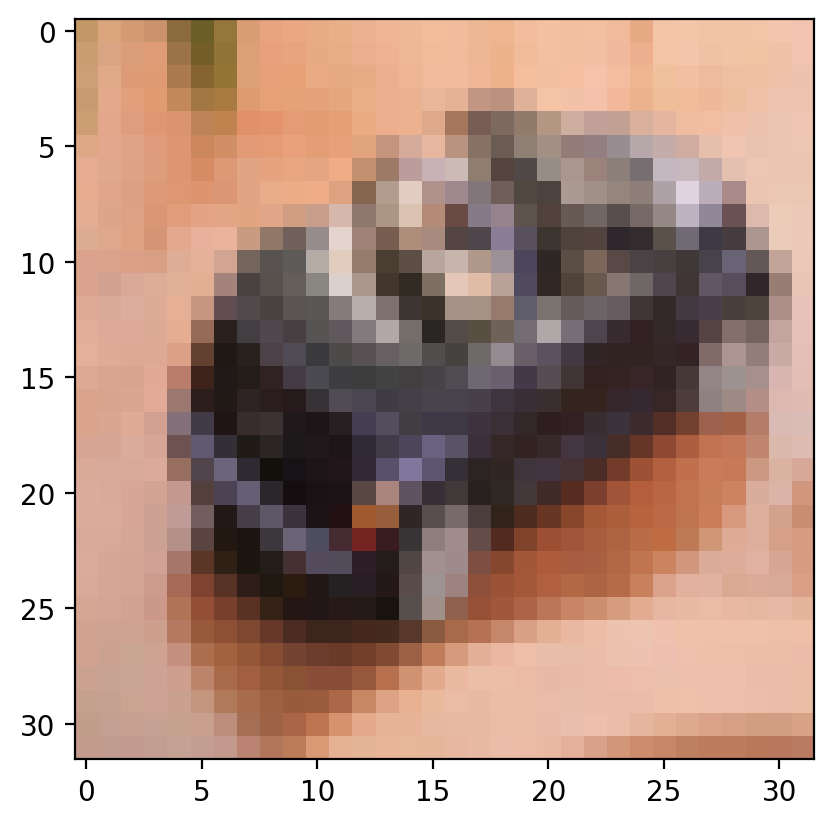

In [16]:
show_example(*dataset[5499])

## Splitting Training and Validation Sets

We need make sure we have sets for training, validation and testing. The test set was already done as part of the download. But we can pull out 5000 images from the training set randomly and use that for the validation during training.

In [17]:
random_seed = 42
torch.manual_seed(random_seed);

In [18]:
validation_size = 5000
train_size = len(dataset) - validation_size

train_ds, val_ds = random_split(dataset, [train_size, validation_size])
len(train_ds), len(val_ds)

(45000, 5000)

Now create the data loaders for each of the sets (train_ds and val_ds), so that we can load data in batches.

In [19]:
batch_size = 128

trainloader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

validloader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

## Defining the CNN Model

Now that data is ready, we can define the model.

Some notes about planning this out:
* Since our images have 3 channels, we need a kernel for each channel and keeping in mind that the outputs are added together pixel-wise. We'll use Conv2d to transform our 3-channel images to a 16-channel feature map.
* The model needs to have max-pooling layers to reduce the sizes of the output from each convolutional layer. We'll use MaxPool2d which will cut the feature map in half each time.
* Finally, we'll add fully connected layers at the end to serve as the classifier part of the model which will take the output of the convolutional part of the model and give us the vector of size 10 (1 per class).


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

### Defining the Model & Helper Functions
We'll define the model by extending an `ImageClassificationBase`

In [20]:
class ImageClassificationBase(nn.Module):
    # This function executes a training step by generating predictions and calculating loss
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    # This function executes the validation step by generating predictions and calculating loss
    # on the validation data. It also calculates the accuracy.
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc} #NOTE: .detach() just keeps the tensor, no gradient info

    # This function puts together all the values from each batch: the losses and accuracy, so we have
    # just one combined value per epoch.
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    # This function prints out the model performance for each epoch so we can track it:
    def epoch_end(self, epochs, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epochs, result['train_loss'], result['val_loss'], result['val_acc']))

        # This function gives an overall percentage accuracy for the model (percent of predictions that were right)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
    

### Put together all the layers into one Network

this network architecture is attributed to excellent tutorial by Shadab Hussain on Kaggle [here](https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch).

In [21]:
class TutorialModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)
    
#''''''Look at the model:''''''
model = TutorialModel()
model

TutorialModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [22]:
# Checking that the model output is in the shape we expect.
# each batch from the trainloader has 128 images and each is a 3, 32, 32 tensor.
# the model should output a vector with 10 elements
for images, labels in trainloader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0196,  0.0411, -0.0260, -0.0372,  0.0459, -0.0270, -0.0140,  0.0326,
         0.0288,  0.0188], grad_fn=<SelectBackward0>)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

#### Wrapping the data and the model reliably based on where the notebook will run:
Handy borrowed helpers to make sure the data and model get moved to GPU (or not) as needed.
This code came from excellent tutorial by Shadab Husain on Kaggle [here](https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch)


In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

In [24]:
# set device based on where the notebook is running:
device = get_default_device()
print(device)


# Wrap the data loaders so that the data and models get moved to the appropriate place:
trainloader = DeviceDataLoader(trainloader, device)
validloader = DeviceDataLoader(validloader, device)
to_device(model, device);

cpu


## Training the Model
Recall the helper functions we created when defining the model:
* training_step(self, batch) - takes the model and batch of images and returns loss
* validation_step(self, batch) - takes the model and batch of images and returns loss and accuracy for the step
* validation_epoch_end(self, outputs) - combines the losses and accuracy scores for the whole epoch
* epoch_end(self, epoch, result) - prints out the epoch's training loss, validation loss and accuracy score
* accuracy(outputs, labels) - compares the prediction to the actual label and computes the average number that were correct.

In [25]:
# Define a function called evaluate that will be used to take a batch from validation data,
# apply the model and return the loss and accuracy for the step and for the epoch overall

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Define a function called fit that will be used for training/validation/seeing training progress:
def fit(epochs, learn_rate, model, trainloader, validloader, optimizer):
    progress = []
    optimizer = optimizer
    for e in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in trainloader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation Phase
        result = evaluate(model, validloader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epochs, result)
        progress.append(result)
    return progress

In [26]:
model = to_device(TutorialModel(), device)

epochs = 10
learn_rate = 0.001

# Loss function:
criterion = nn.CrossEntropyLoss()

# Optimizer:
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

#What are our hp's (just to minimize scrolling)
print('Loss Function: ', criterion)
print('Optimization Function: ', optimizer)
print('Learning Rate: ', learn_rate)

Loss Function:  CrossEntropyLoss()
Optimization Function:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning Rate:  0.001


### Initial model performance
Before the training step, see how model performs using the validation set with initial parameters.

In [55]:
model = to_device(TutorialModel(), device)
print(device)

cuda


In [56]:
evaluate(model, validloader)

{'val_loss': 2.302921772003174, 'val_acc': 0.10629595816135406}

As expected, the untrained model's accuracy is about 10% - same as random guessing.

Now we can train the model for real. For now, we'll keep the same hyperparameters as are already defined. If the results aren't good, we can change them later.

In [57]:
epochs = 10
learn_rate = 0.001

# Loss function:
criterion = nn.CrossEntropyLoss()

# Optimizer:
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

In [58]:
progress = fit(epochs, learn_rate, model, trainloader, validloader, optimizer)

Epoch [10], train_loss: 1.7439, val_loss: 1.4172, val_acc: 0.4797
Epoch [10], train_loss: 1.2236, val_loss: 1.1359, val_acc: 0.5924
Epoch [10], train_loss: 0.9380, val_loss: 0.8723, val_acc: 0.6897
Epoch [10], train_loss: 0.7420, val_loss: 0.7788, val_acc: 0.7322
Epoch [10], train_loss: 0.5972, val_loss: 0.7258, val_acc: 0.7504
Epoch [10], train_loss: 0.4699, val_loss: 0.7394, val_acc: 0.7609
Epoch [10], train_loss: 0.3470, val_loss: 0.8404, val_acc: 0.7296
Epoch [10], train_loss: 0.2542, val_loss: 0.8641, val_acc: 0.7553
Epoch [10], train_loss: 0.1856, val_loss: 0.9358, val_acc: 0.7546
Epoch [10], train_loss: 0.1396, val_loss: 1.0714, val_acc: 0.7521


Plot the training loss (and validation loss/accuracy, if recorded).

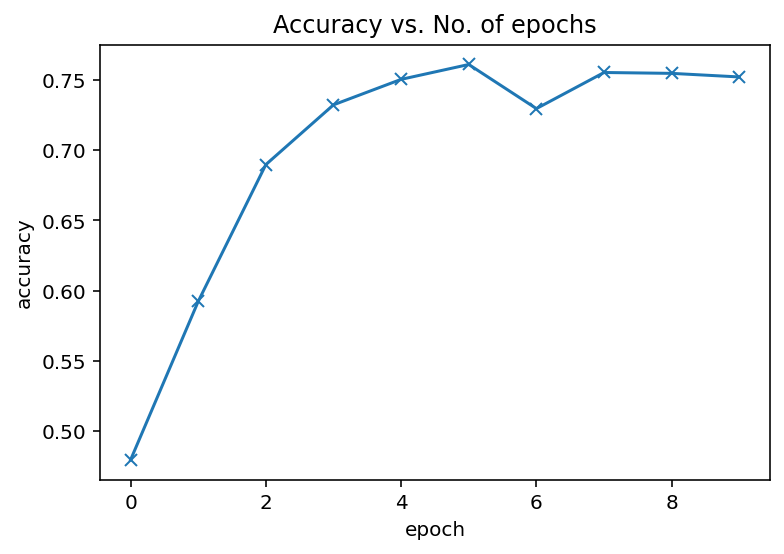

In [59]:
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

accuracies = [x['val_acc'] for x in progress]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');


plt.legend(frameon=False)

The model accuracy gets to about 75%! This seems pretty great. But it could also indicate some overfitting.

We will look at the training and validation errors:

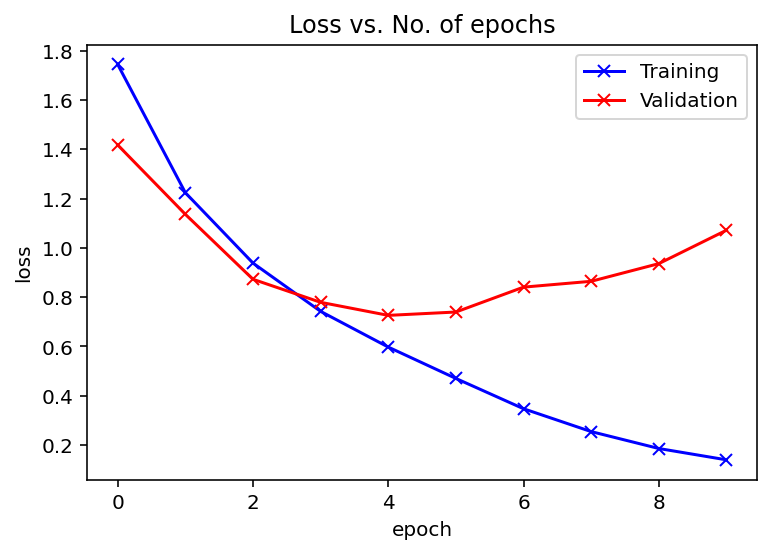

In [62]:
train_losses = [x.get('train_loss') for x in progress]
val_losses = [x['val_loss'] for x in progress]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

It looks like this amount of training might have led us to a model that will over-fit. At around 4 epochs, we can see that the validation loss is actually increasing, while the training loss is still decreasing - this indicates overfitting.

### Retrain with fewer epochs
Let's try to retrain the model but with fewer epochs to see if we can get higher accuracy.

In [27]:
model = to_device(TutorialModel(), device)
print(device)

cpu


In [ ]:
epochs = 5
learn_rate = 0.001

# Loss function:
criterion = nn.CrossEntropyLoss()

# Optimizer:
optimizer = optim.Adam(model.parameters(), lr=learn_rate)
# Clear the gradients
optimizer.zero_grad()

progress_w5 = fit(epochs, learn_rate, model, trainloader, validloader, optimizer)

Epoch [5], train_loss: 0.3363, val_loss: 0.8250, val_acc: 0.7640
Epoch [5], train_loss: 0.2581, val_loss: 0.8630, val_acc: 0.7515


This looks great - and as expected the accuracy looks even better when we use fewer epochs.

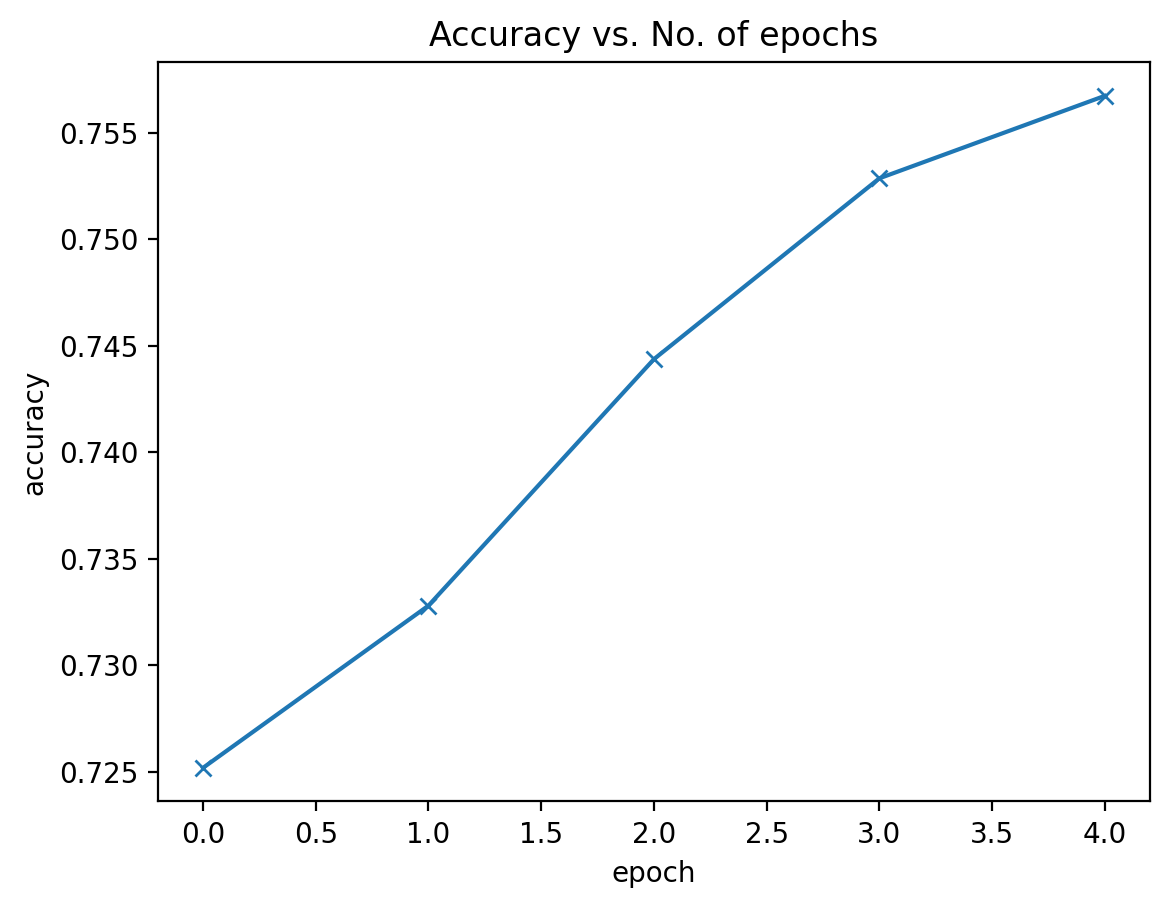

In [48]:
# Let's see what the accuracy over epochs looks like now:
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

accuracies = [x['val_acc'] for x in progress_w5]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');


Conclusion: the model doesn't seem to do quite as well when trained with 5 epochs, but it's still pretty excellent its accuracy score is nearly the same (plus I can train it on my mac in a reasonable amount of time!)

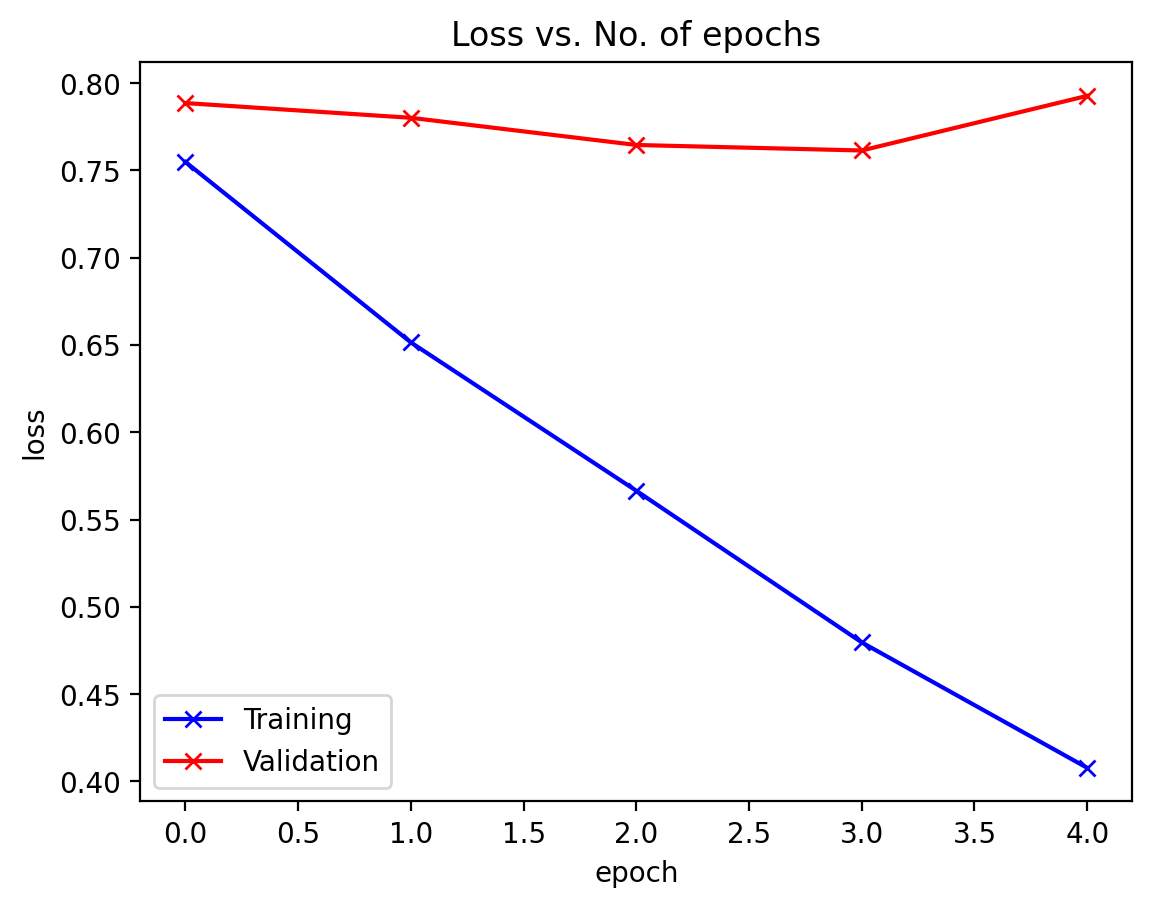

In [36]:
# Let's look at the loss curves as well:
train_losses = [x.get('train_loss') for x in progress_w4]
val_losses = [x['val_loss'] for x in progress_w4]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

So validation loss is consistent with the minimum value we saw when using more epochs - but it's staying more or less constant but training loss is decreasing fast. It's likely the model is overfitting. 
Let's see how the test goes.

In [ ]:
# First, we'll save this model so we can use it again without going through all this training.

In [38]:
# Save the model
model_file = 'cifar10-cnn.pth'
torch.save(model.state_dict(), model_file)


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [39]:
# Create loader for test data:

testset = ImageFolder(data_dir+'/test', transform=ToTensor())

testloader = DataLoader(testset, shuffle=True, num_workers=2, pin_memory=True)

#Wrap the loader so it knows what device is being used:
testloader = DeviceDataLoader(testloader, device)


In [ ]:
# Check that the tensors look as we expect:
for images, labels in testloader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    
    break

In [42]:
# Look at the labels:
print(testset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [46]:
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0].view()


TypeError: 'torch.Size' object is not callable

In [ ]:
# Import helper module (should be in the repo)
import helper

# Make sure the model is in eval mode
model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
#img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Saving your model
Using `torch.save`, save your model for future loading.

In [37]:
# Save the model
model_file = 'cifar10-cnn.pth'
torch.save(model.state_dict(), model_file)


In [ ]:
# To reload the model:
# Recreate a model with the same structure:
modelv2.load_state_dict(torch.load(model_file))


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



**Double click this cell to modify it**

